# Common Library

In [1]:
import os
import sys
import numpy as np 
from scipy.stats import gamma
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import nibabel as nb
from nltools.data import Brain_Data
from collections import Counter
from copy import copy
from nilearn.plotting import plot_design_matrix
from sklearn.linear_model import LinearRegression
from itertools import product
from rsatoolbox import rdm

# rsatoolbox
from rsatoolbox.data.noise import prec_from_residuals
from rsatoolbox.util.searchlight import get_volume_searchlight
from rsatoolbox.data.dataset import Dataset
from rsatoolbox.rdm import calc_rdm

# boostrsa
from boostrsa import searchlight
from boostrsa.boostrsa_types import ShrinkageMethod
from boostrsa.searchlight import calc_sl_rdm_crossnobis

In [2]:
from numba import cuda
cuda.select_device(0)
device = cuda.get_current_device()
print("GPU: ", device)

GPU:  <CUDA device 0 'b'NVIDIA GeForce RTX 3090''>


# Configuration

In [3]:
# Set your cuda path 
os.environ["CUDA_HOME"] = "/usr/local/cuda-12.4" # for linux

# Generate datas

## Simulation parameters

In [218]:
# Brain
brain_shape = (30, 40, 30)
nx, ny, nz = brain_shape
n_vox = nx * ny * nz 

# Mask of brain
mask = np.zeros(brain_shape).astype(np.uint8)
mask[0:30, 0:40, 0:30] = 1

# Create an affine transformation matrix (2mm isotropic voxels, no rotation)
affine = np.diag([2, 2, 2, 1])

# Simulation experiment parameters
n_timepoints = 300  # total time points
stimuli_types = {
    "ISI" : 0,
    "stim1" : 1,
    "stim2" : 2,
    "stim3" : 3,
    "stim4" : 4,
}
stimuli = list(stimuli_types.keys())
response_duration = 10  # duration of response in timepoints
n_run = 3

# HRF Parameters
hrf_times = np.arange(0, 30, 1)  # 30 time points for the HRF
peak = 6
undershoot = 12
ratio = 0.35
hrf = gamma.pdf(hrf_times, peak) - ratio * gamma.pdf(hrf_times, undershoot)

# Response parameter
response_amplitudes = {
    "ISI" : (np.zeros(brain_shape)).astype(np.float16),
    "stim1" : (np.random.random(brain_shape) * 8).astype(np.float16),
    "stim2" : (np.random.random(brain_shape) * 4).astype(np.float16),
    "stim3" : (np.random.random(brain_shape) * 2).astype(np.float16),
    "stim4" : (np.random.random(brain_shape)).astype(np.float16),
}

## Simulate experiment

In [219]:
stimulus_timings_perRun = []
for run_i in range(n_run):
    stimulus_timings = np.zeros(n_timepoints)

    current_time = 0
    while current_time < n_timepoints:
        stimulus = np.random.choice(stimuli)
        onset = current_time
        duration = response_duration
        offset = min(current_time + duration, n_timepoints)

        # Simulate response
        stimulus_timings[onset:offset] += stimuli_types[stimulus]

        # Add inter stimulus interval
        isi = np.random.randint(5, 15)
        current_time += duration + isi
    
    run_stim_df = pd.get_dummies(stimulus_timings.astype(np.uint8))
    run_stim_df.columns = stimuli
    run_stim_df = run_stim_df.astype(np.uint8)
    stimulus_timings_perRun.append(run_stim_df)

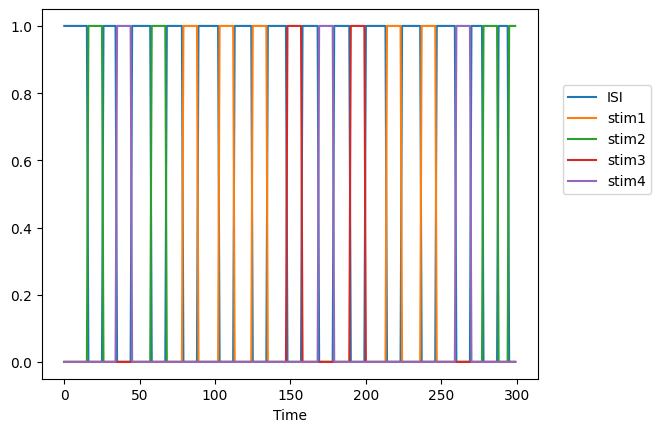

In [220]:
run_i = 0
for stim in stimuli:
    plt.plot(stimulus_timings_perRun[run_i][stim], label = stim)

plt.xlabel("Time")
plt.legend(loc = (1.05, 0.5))

## Simulate brain response

In [221]:
# stimulate reference brain response in correspond to stimulus
reference_brain_response_perRun = copy(stimulus_timings_perRun)
for run_i in range(n_run):
    for stim in stimuli_types:
        reference_brain_response_perRun[run_i][stim] = np.convolve(reference_brain_response_perRun[run_i][stim], hrf, mode = "full")[:n_timepoints]

In [222]:
# population beta 
population_betas = np.array([response_amplitudes[stim] for stim in stimuli])
population_betas = population_betas.reshape(len(stimuli), -1)

In [223]:
# Mask
mask_3d_indexes = np.array(np.where(mask == 1))
mask_1d_indexes = np.ravel_multi_index(mask_3d_indexes, (nx, ny, nz))

In [224]:
noise_level = 2

fmri_data = np.zeros((n_run, n_timepoints, nx, ny, nz)).astype(np.float16)
for run_i in range(n_run):
    reference_activation = reference_brain_response_perRun[run_i].to_numpy()
    
    # population response
    response = (reference_activation @ population_betas).astype(np.float16)
    
    # noise
    noise = np.random.normal(0, noise_level * (run_i+1), n_timepoints) # Add Gaussian noise
    noise = noise.reshape(n_timepoints, 1).astype(np.float16)
    
    response_with_noise = response + noise
    
    # brain response
    fmri_data[run_i, :, :, :] = (response_with_noise).reshape(n_timepoints, nx, ny, nz)
mask_fmri = np.expand_dims(np.expand_dims(mask, 0), 0)
fmri_data = fmri_data[:, :] * mask

# Get beta values & residuals

In [225]:
design_mats = copy(reference_brain_response_perRun)

<Axes: label='conditions', ylabel='scan number'>

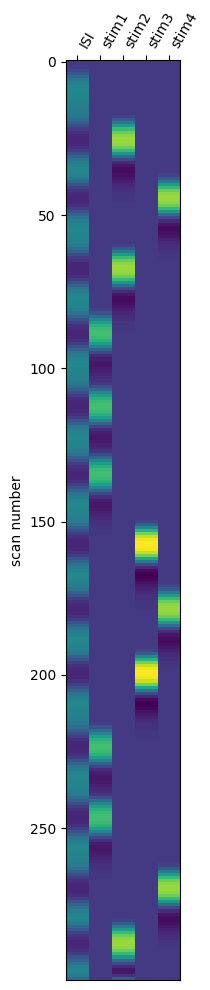

In [226]:
plot_design_matrix(design_mats[0]) # *bias is automatically included in linear regression model

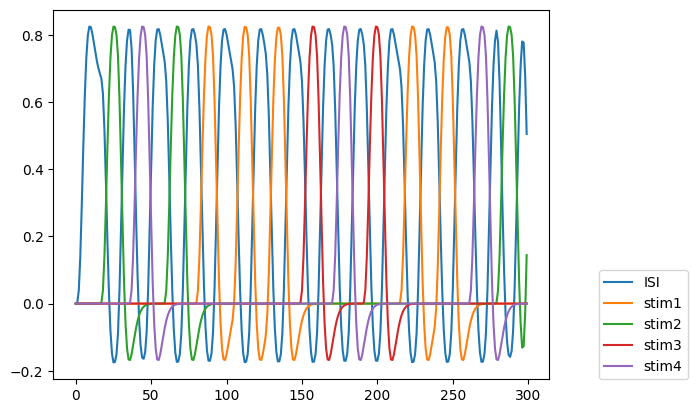

In [227]:
run_i = 0 

plt.plot(design_mats[run_i])
plt.legend(design_mats[run_i].columns, loc = (1.1, 0))

In [228]:
# run, time, nx, ny, nz -> run, nx, ny, nz, time
fmri_data = fmri_data.transpose(0, 2, 3, 4, 1)
fmri_data = fmri_data.astype(np.float32)

In [229]:
model = LinearRegression()

coefficients = np.zeros((n_run, nx, ny, nz, len(stimuli)))
intercepts = np.zeros((n_run, nx, ny, nz))
residuals = np.zeros(fmri_data.shape)

In [230]:
for run_i in tqdm(range(n_run)):
    design_mat = design_mats[run_i]
    
    for j in range(len(mask_3d_indexes[1])):
        # Linear regression
        x,y,z = mask_3d_indexes[:, j]
        target = fmri_data[run_i, x,y,z, :]
        model.fit(design_mat, target)
        
        # Intercept
        intercepts[run_i, x,y,z] = model.intercept_
        
        # Coef
        coefficients[run_i, x,y,z, :] = model.coef_
        
        # Residual
        residual = target - model.predict(design_mat)
        residuals[run_i, x,y,z, :] = residual

100%|██████████| 3/3 [02:13<00:00, 44.55s/it]


# Make appropriate format

Following values' shapes must be matched.

- beta
    - shape: (a number of condition, a number of target voxel)
- residual
    - shape: (a number of session, a number of times on a session, a number of target voxel)
- condition
    - shape (a number of condition)
- session
    - shape: (a number of condition)

In [231]:
betas = coefficients[:, :, :, :, ["stim" in e for e in np.array(stimuli)]]
betas = betas[:, mask_3d_indexes[0, :], mask_3d_indexes[1, :], mask_3d_indexes[2, :], :]
betas = np.concatenate([beta_perRun for beta_perRun in betas], axis = 1)
betas = betas.transpose(1, 0)

In [232]:
residuals = residuals[:, mask_3d_indexes[0, :], mask_3d_indexes[1, :], mask_3d_indexes[2, :], :]
residuals = residuals.transpose(0, 2, 1)

In [233]:
stimuli = np.array(stimuli)
target_stimuli = stimuli[["stim" in e for e in stimuli]]
conditions = np.concatenate([target_stimuli for _ in range(n_run)])

In [234]:
sessions = []
for run_index in range(n_run):
    run_number = run_index + 1
    sessions += [np.repeat(run_number, len(target_stimuli))]
sessions = np.concatenate(sessions)

In [235]:
print("beta shape:", betas.shape)
print("residual shape:", residuals.shape)
print("condition shape:", conditions.shape)
print("session shape:", sessions.shape)

beta shape: (12, 36000)
residual shape: (3, 300, 36000)
condition shape: (12,)
session shape: (12,)


# Searchlight region

In [236]:
radius = 3
threshold = 1

centers, neighbors = get_volume_searchlight(mask, 
                                            radius=radius, 
                                            threshold=threshold)

Finding searchlights...: 100%|██████████| 36000/36000 [00:03<00:00, 10665.67it/s]


Found 36000 searchlights


In [237]:
# Filter voxels which have unmatched neighbors 
n_neighbors = np.array([neighbor.shape[-1] for neighbor in neighbors])
most_n_neighbor = Counter(n_neighbors).most_common(1)[0][0]
flags = n_neighbors == most_n_neighbor

centers = centers[flags]
neighbors = [ne for flag, ne in zip(flags, neighbors) if flag == True]
neighbors = np.array(neighbors)

# Searchlight - CPU version

In [238]:
subj_number = 1

rdm_crossnobis_cpus = []
n_center = len(centers)
for i in tqdm(range(n_center)):
    center = centers[i]
    neighbor = neighbors[i]
    
    # Mask
    n_channel = betas.shape[1]
    mask_out = np.zeros(n_channel)
    for neighbor_pos in neighbor:
        for brain_i, brain_pos in enumerate(mask_1d_indexes):
            if brain_pos == neighbor_pos:
                mask_out[brain_i] = 1
    
    # Beta
    masked_betas = betas[:, mask_out == 1]
    
    # Residual
    masked_residuals = residuals[:, :, mask_out == 1]
    
    # Precision matrix
    noise_precision_mats = prec_from_residuals(masked_residuals, method = ShrinkageMethod.shrinkage_diag)
    
    # Crossnobis
    measurements = masked_betas
    nVox = measurements.shape[-1]
    des = {'subj': subj_number}
    obs_des = {'conds': conditions, 'sessions': sessions}
    chn_des = {'voxels': np.array(['voxel_' + str(x) for x in np.arange(nVox)])}

    dataset = Dataset(measurements = measurements,
                      descriptors = des,
                      obs_descriptors = obs_des,
                      channel_descriptors = chn_des)
    rdm_crossnobis = calc_rdm(dataset, 
                          descriptor = "conds", 
                          method = "crossnobis",
                          noise = noise_precision_mats,
                          cv_descriptor = "sessions")
    rdm_crossnobis_cpus.append(rdm_crossnobis)

  0%|          | 40/24336 [00:18<3:06:14,  2.17it/s]


KeyboardInterrupt: 

# Searchlight - GPU version

In [ ]:
n_split_data = 2048

In [ ]:
# Calculate precision matrix (searchlight)
sl_precisions = searchlight.calc_sl_precision(residuals = residuals,
                                              neighbors = neighbors,
                                              n_split_data = n_split_data,
                                              masking_indexes = mask_1d_indexes,
                                              shrinkage_method = ShrinkageMethod.shrinkage_diag)
sl_precisions = np.concatenate(sl_precisions)

In [ ]:
# Calculate rdm matrix (searchlight)
rdm_crossnobis_gpus, rdm_conds = calc_sl_rdm_crossnobis(n_split_data = n_split_data,
                                                        centers = centers,
                                                        neighbors = neighbors,
                                                        precs = sl_precisions,
                                                        measurements = betas,
                                                        masking_indexes = mask_1d_indexes,
                                                        conds = conditions,
                                                        sessions = sessions)
rdm_crossnobis_gpus = np.concatenate(rdm_crossnobis_gpus)

In [ ]:
# Make sl_rdms
rdm_crossnobis_gpus = rdm.RDMs(rdm_crossnobis_gpus,
                               pattern_descriptors = {
                                   "index" : list(np.arange(0, len(rdm_conds))),
                                   "events" : list(rdm_conds),
                               },
                               rdm_descriptors = {
                                   "voxel_index" : centers,
                                   "index" : np.arange(0, len(centers))
                               })
rdm_crossnobis_gpus.dissimilarity_measure = "crossnobis"

In [ ]:
rdm_crossnobis_gpus